# Class-Schedule
An AI based program for scheduling college courses

### Problem:
Currently class scheduling is done by simply rolling over all of the classes from one year to the next.
Not enough classes for students to take or too many classes, which mean some will be canceled, both lead to stresses for students and faculty.
Although a human could go through the data and manually predict how many classes are needed based on the number of students, this process is slow, tedious, and prone to error.

### Solution:
Build an A.I. model that could look through the data and make accurate predictions on the number of classes needed.


### Problems:
Although there should be a linear relation to class sizes from one year to the next, this isn't always the case. The pandemic was a perfect example of this.
Some students dropped out for an entire year taking what should be a class of 15 down to a class of 10.
The next year these students returned and the class which should have only had 10 went to 15 because of the returning students. There is also a severe lack of data to train the model accurately on. 

### Initial assumptions and failures
##### More columns better outcome 
I Initially assumed that using more columns of data would be better. This proved incorrect since there wasn't enough training data, the model would train on unrelated columns.
##### Data consistency
I had assumed that each fall semester the class and section numbers would be the same and only the number of students would vary. I found that the section numbers would sometimes change from semester to semester making it impossible to use section numbers. These had to be stripped off and two of the same classes (different section) would have to be added together. e.g.  HVC-070_12345 with 12 students and HVC-070-54321 with 10 students would have to be combined to just HVC-070 with 22 students.  
###### LinearRegression
I assumed that the data would all have linear outcomes e.g. the freshman numbers would be >= sophomore numbers. This too was not the case and so I opted for a model that could deal with nonlinear data better. 
##### Coding errors
I found that my X_test data was also in my X_train data. Basically the model just memorized the correct outcome from the training data and spit it out as a prediction. This made the prediction 100% accurate everytime. I was super impressed, but very leary of this result. Once I actually used new data that wasn't in any of my orginal spreadsheets it became very obvious that something was wrong, as it would predict 140 students in a sophomore class when there were only 24 freshman students. 


### Program overview:
This program predicts the number of students that will be in each of the Spring HVAC-R classes based on the number of students in the Fall HVAC-R. 
HVAC-R was just a random certificate program. The program can be changed by entering Fall program classes in the Auto_program_list and Spring semester classes in the Predict List 


Get class data from:
https://www.lakelandcollege.edu/wp-content/mu-plugins/Laker/as/as/acad_prog/gps_model.php?acadprog=CRT.HVAC&catalog_term=22FA

- Enter Fall classes in Auto_program_list
- Enter Spring classes in Predict_list

In [46]:
Auto_program_list=['HVC-062','IND-043','HVC-066']
Predict_list=['HVC-068','HVC-070','HVC-072' ]

### Imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm

The data is stored in an .xlxs file with multiple tabs for each of the semesters data.
It contains every class offered on and off campus for that year and semester. 
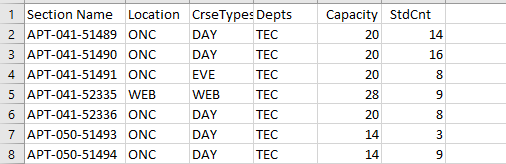


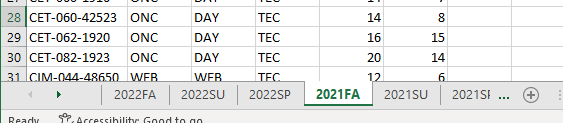

### Load the class data
Iterate through the semesters in the Semesters list and read each one into memory. 
Ok, they are actually stored in the dictionary d={}, but you can think of it as memory.

In [48]:
# read each sheet of the excel file
d={}    #create blank dictionary to store info in
Semesters=('FA2017','SP2017','FA2018','SP2018','FA2019','SP2019','FA2020','SP2020','FA2021','SP2021', 'FA2022', 'SP2022')
for Semester in Semesters: #Iterate through and store the xlxs files 
    d[Semester] = pd.read_excel('Data/Technology Student Counts.xlsx', sheet_name = Semester[2:]+ Semester[:2])
   

### Remove classes
Remove the classes that someone else schedules, such as dual credit or department of corrections.
Also remove classes that don't have a student count.

In [49]:
#Lots of space padded data. Sometimes before, sometimes after.
#Get rid of EXCO, EXCL, and stdcnt blank data rows 

values = ['EXCO        ', 'EXCL        ', '       ']
for Semester in Semesters:
    d[Semester] =  d[Semester][ d[Semester]['Location    '].isin(values) == False]
    d[Semester] =  d[Semester][ d[Semester]['  StdCnt'].isin(values) == False]
    #print(Semester,d[Semester])

#### More data formating
In the code below we basically do 3 steps. 
#### Step 1
- Remove the remaining unwanted columns of data: Location, CrseTypes , Depts, Capacity 
- Convert student counts to integer
- Transpose the data : rows to columns and vis a versa
    
#### Step 2
- Get a list of classes to keep : Auto_program_list and Predict_list
- Drop any classes not on those lists

#### Step 3
- Reformat the remaing classes into a new dataframe called Fall_df

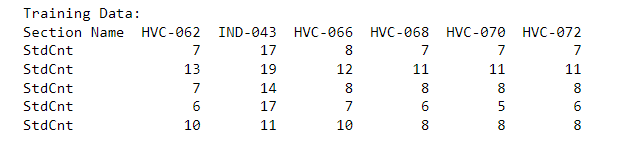

This is now a list of major classes by year with the student counts.
This is the data the model will train on.
##### Small training set
I'm sure you can see there isn't much data left to train on. Many models have thousands of row of training data. 

In [50]:

#*********************************************Step 1********************************

fall_df = pd.DataFrame()                                                 #Create empty Datafram
keep_list=Auto_program_list                                              #Set the files to keep using the Auto_program_list 
for Semester in Semesters:
    d[Semester+'d'] =  d[Semester].drop(['Location    ', 'CrseTypes   ','Depts ', '  Capacity'],
                                        axis=1).set_index('Section Name') #Remove unwanted columns
    d[Semester+'d'] = d[Semester+'d']['  StdCnt'].astype(str).astype(int) #Change StdCnt str to integer
    d[Semester+'d'] = pd.DataFrame(d[Semester+'d'])                       #Create new dataframes

                                                  
    d['dt'+Semester] = d[Semester+'d'].T                                  #transform -rows to columns and vis a versa
            
#*********************************************Step 2********************************   
    pred= d['dt'+Semester]                          #Load a xlsx file 
    test=pred.columns                               #Get just the column names
    
    for i in range(len(test)):
        k =test[i][0:7]                             # removes the section number from course number
        drop=0                                      # resets whether to drop or not 

    if Semester[:2] == 'FA':
        keep_list=Auto_program_list
    else:
        keep_list=Predict_list
    for keep in (keep_list):
            if k in keep:                           #If the class # (k) = a class on the list
                drop = drop+1                       #don't drop
            
    if drop == 0:                                   # If the class number doesn't == to a class on the list 
          
        pred.drop(test[i], axis =1, inplace = True) #drop it.

#*********************************************Step 3********************************  
fall_df=pd.DataFrame()                                   #Make blank DataFrame
size=0                                                   #Set size = 0

c={}                                                     #Make dictionaty
fall_df=pd.DataFrame()                                   #make empty dataframe
for Semester in Semesters[:-3]:                          #iterate through each semester
    #print(d['dtSP'+str(int(Semester[2:])+1)])
    #print(Semester, d['dt'+Semester])
    Courses=[]                                           #create blank Couses list
    sizes=[]                                             #create blank sizes list
    fall_df2=[]                                          #create enpty Fall_df2 list
    if Semester[:2] == 'FA':                             #only do the fall semesters
        for class_num in Auto_program_list:              #look at each individual class in the list
            #print(class_num[:3]+class_num[4:])
            c[class_num[:3]+class_num[4:]] =d['dt'+Semester].filter(regex=class_num,axis=1).sum() #filter out all other classes

            size=0
            for i in range(len(c[class_num[:3]+class_num[4:]])):    #get the number of students in the class (strip '-')
                    size=size+int(c[class_num[:3]+class_num[4:]][i])# add up if there is more than one section 
                    #print(size)
           # print(class_num[:3]+class_num[4:],'=',size)            #set dictionary entry
            c[class_num] =class_num[:3]+class_num[4:],size          #list of class mnumbers
            Courses.append(class_num)             #list of class sizes 
            sizes.append(size)
            
        for class_num in Predict_list:                              #Get the classes I want predictions for too
            #print(class_num)
            c[class_num[:3]+class_num[4:]] =d['dtSP'+str(int(Semester[2:])+1)].filter(regex=class_num,axis=1).sum()
        #d['dtSP'+str(int(Semester[2:])+1)].filter(regex='HVC-072',axis=1).sum()   
            size=0
            for i in range(len(c[class_num[:3]+class_num[4:]])):
                    size=size+int(c[class_num[:3]+class_num[4:]][i])
                    #print(size)
            Courses.append(class_num)
            sizes.append(size)
  
        fall_df2 = pd.DataFrame(list(zip(Courses, sizes)), columns =['Section Name', 'StdCnt']).set_index('Section Name')
        fall_df2 = fall_df2.T                                      #zip the 2 lists together and transpose
        fall_df=fall_df.append(fall_df2)                           #append to the list of fall classes )By year)
        

print('Training Data:')
print(fall_df)                                                     
 


Training Data:
Section Name  HVC-062  IND-043  HVC-066  HVC-068  HVC-070  HVC-072
StdCnt              7       17        8        7        7        7
StdCnt             13       19       12       11       11       11
StdCnt              7       14        8        8        8        8
StdCnt              6       17        7        6        5        6
StdCnt             10       11       10        8        8        8


#### Get data from the last Fall semester.

Get the class sizes from last Fall semester and use that to predict the Spring semester.

In [51]:
 
c={}                                                            #Make dictionaty
                                                                #make emptydataframe
Semester ='FA2022'                                              #last semester
#print(d['dtSP'+str(int(Semester[2:])+1)])
#print(Semester, d['dt'+Semester])
Courses=[]                                                      #create blank Couses list
sizes=[]                                                        #create blank sizes list
fall_df2=[]                                                     #create enpty Fall_df2 list
if Semester[:2] == 'FA':                                        #only do the fall semesters
                                
    for class_num in Auto_program_list:                         #look at each individual class in the list
        c[class_num[:3]+class_num[4:]] =d['dt'+Semester].filter(regex=class_num,axis=1).sum() #filter out all other classes
        size=0
        for i in range(len(c[class_num[:3]+class_num[4:]])):    #get the number of students in the class
                size=size+int(c[class_num[:3]+class_num[4:]][i])# add up if there is more than one section 
        c[class_num] =class_num[:3]+class_num[4:],size          
        Courses.append(class_num)                               #list of class numbers
        sizes.append(size)                                      #list of class sizes 
  
    x_test = pd.DataFrame(list(zip(Courses, sizes)), columns =['Section Name', 'StdCnt']).set_index('Section Name')
    x_test = x_test.T                                           #zip the 2 lists together and transpose
print('Data from',Semester,'to make predcition on')            
print(x_test)



Data from FA2022 to make predcition on
Section Name  HVC-062  IND-043  HVC-066
StdCnt              9       14        9


## And now the moment you have been waiting for...
In this section we will set up our GBR model.
#### GBR
GBR or GradientBoostingRegressor is algorithm that produces several weak models and then combines them to make a better one. 
Think of working with a team to solve a problem verses working by yourself. Except this team doesn't have any drama.
GBR is usually good at working with data that may not be linear. Normally you would think that class sizes from one semester would be linear because you might lose some people along the way.
There are reasons why it may not be that way. The Pandemic caused some non-linearity when students droped out for a year or two and then came back.
This made the class data for sophomores sometimes larger than the freshman classes. A good article on GBR can be found here: https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502
#### GridSearchCV
I have also used a GridSearch that tries every parameter combination to see which ones will fit the data the best.
I left the printout turned on so you can see that it picked different parameters for each Spring class. 
### Training the model
The model trains off the data we looked at a couple of steps above. Except it hold out one row of data that it hasn't seen as a test set.
it changes the parameters one at a time and tries to get close to the y_train data using just the X_train data. Whatever combination gets the best score it keeps and then tries the unseen X_test. 
Once it is trained it uses the test set X_test to see if it can predict the courses of y_test. The closer it gets to the correct number the better the score.
You can see the training MSE and Testing MSE scores in the final output of the program.
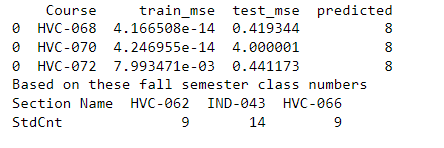

### Predict
Once the final training and testing are done. The best parameters are kept and we 'predict' the class size numbers. Row 25 "predicted": round(grid_GBR.predict(x_test)[0]) uses the data in x_test to predict the numbers for our Spring class in the Predict_List

In [52]:
model_stats=pd.DataFrame()
df1=pd.DataFrame() #empty data frames for model comparisons

Course_data_df=pd.DataFrame()
GBR = GradientBoostingRegressor()
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10],
              }
old_courses=fall_df
Course_data_df=pd.DataFrame()
for course in Predict_list:
    X = old_courses.drop((Predict_list), axis =1)
    y = old_courses[course]
    X_train,  X_test, y_train, y_test = train_test_split(X,y, test_size = .125)
    grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
    grid_GBR.fit(X_train, y_train)  

    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
    print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
    print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)
    
    train_mse = mean_squared_error(y_train, grid_GBR.predict(X_train))
    test_mse = mean_squared_error(y_test, grid_GBR.predict(X_test))         
    cd_df=pd.DataFrame({'Course':[course], "train_mse":[train_mse], "test_mse":[test_mse], "predicted":[round(grid_GBR.predict(x_test)[0])]})
    Course_data_df=Course_data_df.append(cd_df)
    mean_fit_time= grid_GBR.cv_results_['mean_fit_time']
    mean_score_time= grid_GBR.cv_results_['mean_score_time']
print(Course_data_df)
print('Based on these fall semester class numbers')
print(x_test)
df1['Model']=['GradientBoostingRegressor']
df1['Mean Fit Time']= [sum(mean_fit_time)/len(mean_fit_time)]
df1['Mean Score Time']= [sum(mean_score_time)/len(mean_score_time)]


model_stats=model_stats.append(df1)
print(df1)



 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.04, max_depth=10, n_estimators=1500,
                          subsample=0.9)

 The best score across ALL searched params:
 -0.25044284998540634

 The best parameters across ALL searched params:
 {'learning_rate': 0.04, 'max_depth': 10, 'n_estimators': 1500, 'subsample': 0.9}
 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.04, max_depth=10, n_estimators=1000,
                          subsample=0.9)

 The best score across ALL searched params:
 -3.1542079489068193

 The best parameters across ALL searched params:
 {'learning_rate': 0.04, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.9}
 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.03, max_depth=6, subsample=0.9)

 The best score across ALL searched params:
 -0.207879211

### The models - Why I choose GradientBoostingRegressor
I ran several additional models and each gave the same predictions. With predictions all being the same I looked at speeds.
You may notice several warnings for the different models. It appears that due to the low sample size the models struggle with the grid search parameters. 


In [53]:
Course_data_df=pd.DataFrame()
KNN_default = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
#y_pred_KNN_default =KNN_default.predict(X_test)

estimator_KNN = KNeighborsClassifier(('scale', StandardScaler()),algorithm='auto')

parameters_KNN = {
    'n_neighbors': (1,2,3,4),
    'leaf_size': (1,5,10),
    'weights': ('uniform', 'distance')}
for course in Predict_list:
    grid_search_KNN = GridSearchCV(
        estimator=estimator_KNN,
        param_grid=parameters_KNN,
        scoring = 'accuracy',
        n_jobs = -1,
        cv = 2).fit(X_train, y_train)

    knn_train_score = grid_search_KNN.score(X_train,y_train)
    knn_test_score = grid_search_KNN.score(X_test,y_test)

    print('Best Paramaters:' ,grid_search_KNN.best_params_) 
    print('Best Score - KNN:', grid_search_KNN.best_score_ )

    mean_fit_time= grid_search_KNN.cv_results_['mean_fit_time']
    mean_score_time= grid_search_KNN.cv_results_['mean_score_time']
    n_splits  = grid_search_KNN.n_splits_ #number of splits of training data
    n_iter = pd.DataFrame(grid_search_KNN.cv_results_).shape[0] #Iterations per split

    print('Run Time', np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)

    KNN_1=grid_search_KNN.fit(X_train, y_train)
    y_pred_KNN1 =KNN_1.predict(x_test)
    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n",grid_search_KNN.best_estimator_)
    print("\n The best score across ALL searched params:\n",grid_search_KNN.best_score_)
    print("\n The best parameters across ALL searched params:\n",grid_search_KNN.best_params_)
    
    train_mse = mean_squared_error(y_train, grid_search_KNN.predict(X_train))
    test_mse = mean_squared_error(y_test, grid_search_KNN.predict(X_test))         
    cd_df=pd.DataFrame({'Course':[course], "train_mse":[train_mse], "test_mse":[test_mse], "predicted":[round(grid_search_KNN.predict(x_test)[0])]})
    Course_data_df=Course_data_df.append(cd_df)
print(Course_data_df)
print('Based on these fall semester class numbers')
print(x_test)
df1['Model']=['KNN']
df1['Mean Fit Time']= [sum(mean_fit_time)/len(mean_fit_time)]
df1['Mean Score Time']= [sum(mean_score_time)/len(mean_score_time)]


model_stats=model_stats.append(df1)
print(df1)


Best Paramaters: {'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}
Best Score - KNN: 0.25
Run Time 0.20347881317138672
 Results from Grid Search 

 The best estimator across ALL searched params:
 KNeighborsClassifier(leaf_size=1, n_neighbors=1)

 The best score across ALL searched params:
 0.25

 The best parameters across ALL searched params:
 {'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}
Best Paramaters: {'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}
Best Score - KNN: 0.25
Run Time 0.13280057907104492


C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.25 0.25 0.   0.25  nan  nan  nan  nan 0.25 0.25 0.   0.25  nan  nan
  nan  nan 0.25 0.25 0.   0.25  nan  nan  nan  nan]
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.25 0.25 0.   0.25  nan  nan  nan  nan 0.25 0.25 0.   0.25  nan  nan
  nan  nan 0.25 0.25 0.   0.25  nan  nan  nan  nan]
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\skl

 Results from Grid Search 

 The best estimator across ALL searched params:
 KNeighborsClassifier(leaf_size=1, n_neighbors=1)

 The best score across ALL searched params:
 0.25

 The best parameters across ALL searched params:
 {'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}
Best Paramaters: {'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}
Best Score - KNN: 0.25
Run Time 0.12668704986572266
 Results from Grid Search 

 The best estimator across ALL searched params:
 KNeighborsClassifier(leaf_size=1, n_neighbors=1)

 The best score across ALL searched params:
 0.25

 The best parameters across ALL searched params:
 {'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}
    Course  train_mse  test_mse  predicted
0  HVC-068        0.0      16.0          8
0  HVC-070        0.0      16.0          8
0  HVC-072        0.0      16.0          8
Based on these fall semester class numbers
Section Name  HVC-062  IND-043  HVC-066
StdCnt              9       14        9
  Model  

C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.25 0.25 0.   0.25  nan  nan  nan  nan 0.25 0.25 0.   0.25  nan  nan
  nan  nan 0.25 0.25 0.   0.25  nan  nan  nan  nan]
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.25 0.25 0.   0.25  nan  nan  nan  nan 0.25 0.25 0.   0.25  nan  nan
  nan  nan 0.25 0.25 0.   0.25  nan  nan  nan  nan]
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\skl

In [54]:
Course_data_df=pd.DataFrame()
pca = PCA()
estimator_lr = LogisticRegression(max_iter=1000,multi_class='auto')

parameters_lr = {"penalty":['l1', 'l2', 'elasticnet'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear'],}
for course in Predict_list:   
    grid_search_lr = GridSearchCV(
        estimator=estimator_lr,
        param_grid=parameters_lr,
        scoring = 'accuracy',
        n_jobs = -1,
        cv = 2).fit(X_train, y_train)

    lr_train_score = grid_search_KNN.score(X_train,y_train)
    lr_test_score = grid_search_KNN.score(X_test,y_test)

    print('Best Paramaters:' ,grid_search_lr.best_params_) 
    print('Best Score - KNN:', grid_search_lr.best_score_ )

    mean_fit_time= grid_search_lr.cv_results_['mean_fit_time']
    mean_score_time= grid_search_lr.cv_results_['mean_score_time']
    n_splits  = grid_search_lr.n_splits_ #number of splits of training data
    n_iter = pd.DataFrame(grid_search_lr.cv_results_).shape[0] #Iterations per split

    print('Run Time', np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)

    lr1=grid_search_lr.fit(X_train, y_train)
    y_pred_lr1 =grid_search_lr.predict(x_test)
    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n",grid_search_lr.best_estimator_)
    print("\n The best score across ALL searched params:\n",grid_search_lr.best_score_)
    print("\n The best parameters across ALL searched params:\n",grid_search_lr.best_params_)
   
    train_mse = mean_squared_error(y_train, grid_search_lr.predict(X_train))
    test_mse = mean_squared_error(y_test, grid_search_lr.predict(X_test))         
    cd_df=pd.DataFrame({'Course':[course], "train_mse":[train_mse], "test_mse":[test_mse], "predicted":[round(grid_search_lr.predict(x_test)[0])]})
    Course_data_df=Course_data_df.append(cd_df)
print(Course_data_df)
print('Based on these fall semester class numbers')
print(x_test)
df1['Model']=['LogisticRegression']
df1['Mean Fit Time']= [sum(mean_fit_time)/len(mean_fit_time)]
df1['Mean Score Time']= [sum(mean_score_time)/len(mean_score_time)]



model_stats=model_stats.append(df1)
print(df1)



C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\micha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver =

Best Paramaters: {'penalty': 'l2', 'solver': 'newton-cg'}
Best Score - KNN: 0.25
Run Time 0.03690338134765625
 Results from Grid Search 

 The best estimator across ALL searched params:
 LogisticRegression(max_iter=1000, solver='newton-cg')

 The best score across ALL searched params:
 0.25

 The best parameters across ALL searched params:
 {'penalty': 'l2', 'solver': 'newton-cg'}
Best Paramaters: {'penalty': 'l2', 'solver': 'newton-cg'}
Best Score - KNN: 0.25
Run Time 0.03590083122253418
 Results from Grid Search 

 The best estimator across ALL searched params:
 LogisticRegression(max_iter=1000, solver='newton-cg')

 The best score across ALL searched params:
 0.25

 The best parameters across ALL searched params:
 {'penalty': 'l2', 'solver': 'newton-cg'}
Best Paramaters: {'penalty': 'l2', 'solver': 'newton-cg'}
Best Score - KNN: 0.25
Run Time 0.035903215408325195
 Results from Grid Search 

 The best estimator across ALL searched params:
 LogisticRegression(max_iter=1000, solver='ne

C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\micha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver =

In [55]:
Course_data_df=pd.DataFrame()
estimator_svc = svm.SVC()
parameters_svc = {'kernel':('sigmoid', 'rbf'),'gamma': (1,2,3,'auto'), 'C':[0.25,0.5,0.75,1, 10]}
for course in Predict_list:
    grid_search_svc = GridSearchCV(
        estimator=estimator_svc,
        param_grid=parameters_svc,
        cv = 2).fit(X_train, y_train)

    svc_train_score = grid_search_svc.score(X_train,y_train)
    svc_test_score = grid_search_svc.score(X_test,y_test)

    print('Best Paramaters:' ,grid_search_svc.best_params_) 
    print('Best Score - svc:', grid_search_svc.best_score_ )

    mean_fit_time= grid_search_svc.cv_results_['mean_fit_time']
    mean_score_time= grid_search_svc.cv_results_['mean_score_time']
    n_splits  = grid_search_svc.n_splits_ #number of splits of training data
    n_iter = pd.DataFrame(grid_search_svc.cv_results_).shape[0] #Iterations per split

    print('Run Time', np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)

    svc_1=grid_search_svc.fit(X_train, y_train)
    y_pred_svc1 =svc_1.predict(X_test)
    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n",grid_search_svc.best_estimator_)
    print("\n The best score across ALL searched params:\n",grid_search_svc.best_score_)
    print("\n The best parameters across ALL searched params:\n",grid_search_svc.best_params_)
    
    train_mse = mean_squared_error(y_train, grid_search_svc.predict(X_train))
    test_mse = mean_squared_error(y_test, grid_search_svc.predict(X_test))         
    cd_df=pd.DataFrame({'Course':[course], "train_mse":[train_mse], "test_mse":[test_mse], "predicted":[round(grid_search_svc.predict(x_test)[0])]})
    Course_data_df=Course_data_df.append(cd_df)
print(Course_data_df)
print('Based on these fall semester class numbers')
print(x_test)
df1['Model']=['SVC']
df1['Mean Fit Time']= [sum(mean_fit_time)/len(mean_fit_time)]
df1['Mean Score Time']= [sum(mean_score_time)/len(mean_score_time)]



model_stats=model_stats.append(df1)
print(df1)


C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Best Paramaters: {'C': 0.25, 'gamma': 1, 'kernel': 'sigmoid'}
Best Score - svc: 0.5
Run Time 0.15060210227966309
 Results from Grid Search 

 The best estimator across ALL searched params:
 SVC(C=0.25, gamma=1, kernel='sigmoid')

 The best score across ALL searched params:
 0.5

 The best parameters across ALL searched params:
 {'C': 0.25, 'gamma': 1, 'kernel': 'sigmoid'}


C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Best Paramaters: {'C': 0.25, 'gamma': 1, 'kernel': 'sigmoid'}
Best Score - svc: 0.5
Run Time 0.14960551261901855
 Results from Grid Search 

 The best estimator across ALL searched params:
 SVC(C=0.25, gamma=1, kernel='sigmoid')

 The best score across ALL searched params:
 0.5

 The best parameters across ALL searched params:
 {'C': 0.25, 'gamma': 1, 'kernel': 'sigmoid'}


C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
C:\Users\micha\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Best Paramaters: {'C': 0.25, 'gamma': 1, 'kernel': 'sigmoid'}
Best Score - svc: 0.5
Run Time 0.1466374397277832
 Results from Grid Search 

 The best estimator across ALL searched params:
 SVC(C=0.25, gamma=1, kernel='sigmoid')

 The best score across ALL searched params:
 0.5

 The best parameters across ALL searched params:
 {'C': 0.25, 'gamma': 1, 'kernel': 'sigmoid'}
    Course  train_mse  test_mse  predicted
0  HVC-068       1.25       9.0          8
0  HVC-070       1.25       9.0          8
0  HVC-072       1.25       9.0          8
Based on these fall semester class numbers
Section Name  HVC-062  IND-043  HVC-066
StdCnt              9       14        9
  Model  Mean Fit Time  Mean Score Time
0   SVC       0.001022         0.000811


In [56]:
print(model_stats)

                       Model  Mean Fit Time  Mean Score Time
0  GradientBoostingRegressor       0.221735         0.001854
0                        KNN       0.001286         0.001353
0         LogisticRegression       0.001496         0.000499
0                        SVC       0.001022         0.000811


### Speed
Looking at the table above, it is easy to see that GradientBoostingRegressor (GBR) is the slowest of the 4 models.
The Model fit time and Model Mean score time also show that GBR is the slowest.
However, since the GBR model had more grid search parameters, and could actually run all of them without warning I still feel it is the best model to use.

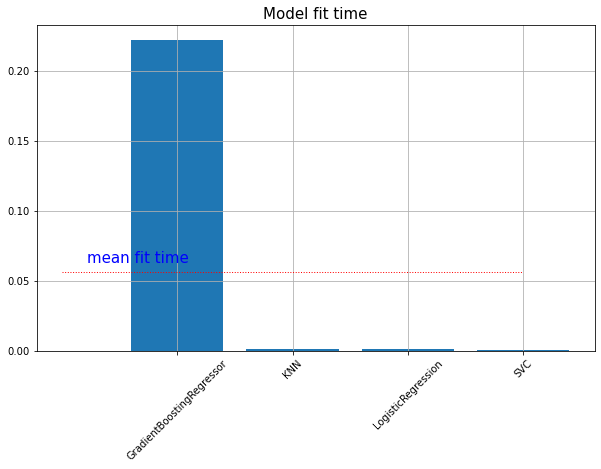

In [57]:
avg=model_stats['Mean Fit Time'].mean()
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(model_stats["Model"], model_stats["Mean Fit Time"])
plt.hlines(y=avg,xmin=-1,xmax=3,ls=':',lw=1,color='red')
ax.annotate('mean fit time',ha='right',va='center', xy = (0, 0), xytext=(0.1,avg+.01),fontsize=15,color='blue')
plt.title('Model fit time',fontsize=15)
plt.xticks(rotation = 45)
plt.grid(b=None, which='major', axis='both')

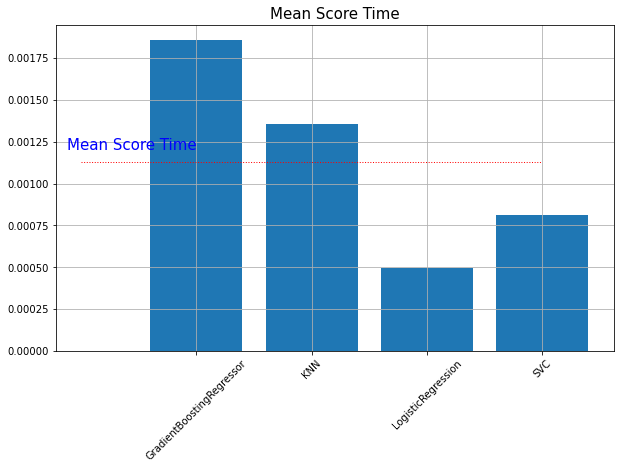

In [58]:
avg=model_stats['Mean Score Time'].mean()
fig,ax = plt.subplots(figsize=(10,6))
ax.bar(model_stats["Model"], model_stats["Mean Score Time"])
plt.hlines(y=avg,xmin=-1,xmax=3,ls=':',lw=1,color='red')
ax.annotate('Mean Score Time',ha='right',va='center', xy = (0, 0), xytext=(0.0001,avg+.0001),fontsize=15,color='blue')
plt.title('Mean Score Time',fontsize=15)
plt.xticks(rotation = 45)
plt.grid(b=None, which='major', axis='both')

### Conclusion:
The model predicts the class numbers reasonably well, enough that if it predicts more students than a class can hold, I would feel comfortable scheduling a new class section. Even though GBR is the slowest model, it was selected because it  seemed to deal with the limited data size the best (no warnings).
With that being said, more years of data might be helpful here.  It would also be useful to train with the added data of the number of students in the major I am trying to predict. Sometimes just adding or removing a particular year’s data causes the model to predict more students in a class than there were in the entire major. 
